In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import plotly.graph_objects as go

In [2]:
pisa = pd.read_csv('data/notas_pisa.csv', delimiter=',')
# Fonte: https://pisadataexplorer.oecd.org/ide/idepisa/report.aspx

In [3]:
# Informações gerais do dataset
pisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           96 non-null     object
 1   group             96 non-null     object
 2   mathematics_2022  96 non-null     object
 3   reading_2022      96 non-null     object
 4   science_2022      96 non-null     object
 5   mathematics_2018  96 non-null     object
 6   reading_2018      96 non-null     object
 7   science_2018      96 non-null     object
dtypes: object(8)
memory usage: 6.1+ KB


In [4]:
# Analise apenas das notas de 2022

pisa.drop(columns=['mathematics_2018', 'reading_2018', 'science_2018'], inplace=True)

In [5]:
# Ajustando as variáveis de notas para numéricas

pisa['mathematics_2022'] = pd.to_numeric(pisa['mathematics_2022'], errors='coerce')
pisa['reading_2022'] = pd.to_numeric(pisa['reading_2022'], errors='coerce')
pisa['science_2022'] = pd.to_numeric(pisa['science_2022'], errors='coerce')

In [6]:
# Há valores faltantes "nan", serão removidos

pisa.dropna(inplace=True)

In [7]:
# Iniciando a análise fatorial PCA

pisa_pca = pisa.drop(columns=['country', 'group'])

<Axes: >

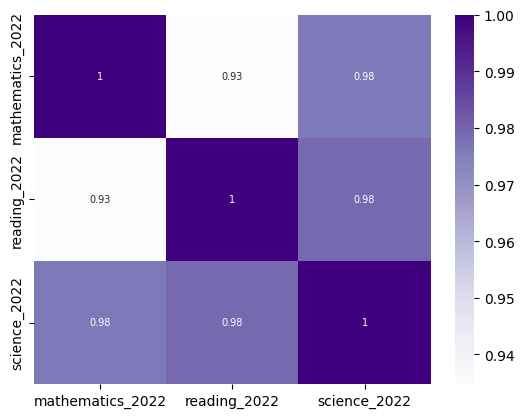

In [8]:
# Análise gráfica das correlações de Pearson

matriz_corr = pisa_pca.corr()

sns.heatmap(matriz_corr, annot=True, 
            cmap = plt.cm.Purples,
            annot_kws={'size':7})

In [9]:
# Estatísticas descritivas

pisa_pca.describe()

,mathematics_2022,reading_2022,science_2022
count,81.000000,81.000000,81.000000
mean,437.628559,435.037917,446.893945
std,58.219370,56.104751,55.724807
min,336.396041,328.842780,347.104162
25%,388.781607,386.284748,403.130242
50%,440.845309,438.440625,446.967114
75%,483.159455,480.405847,493.549319
max,574.663820,542.553322,561.433275


In [10]:
# Teste de Esfericidade de Bartlett

bartlett, p_value = calculate_bartlett_sphericity(pisa_pca)
print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 508.46
p-valor: 0.0


In [11]:
# Definindo a PCA (procedimento inicial com todos os fatores possíveis)

fa = FactorAnalyzer(n_factors=3, method='principal', rotation=None).fit(pisa_pca)

In [12]:
# Obtendo todos os possíveis autovalores

autovalores = fa.get_eigenvalues()[0]
print(autovalores)

[2.92687872 0.06529156 0.00782972]


*Pode-se observar que quase toda variância ocorre já no primeiro fator, justificando-se assim a seleção de apenas um fator para a análise*

In [13]:
# Redefinindo a PCA (critério da raiz latente)

# Escolhendo n_factors com base em autovalores > 1

fa = FactorAnalyzer(n_factors=1, method='principal', rotation=None).fit(pisa_pca)

In [14]:
# Eigenvalues, variâncias e variâncias acumuladas

autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   2.926879   0.975626             0.975626


In [15]:
# Determinando as cargas fatoriais

cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = pisa_pca.columns

print(tabela_cargas)

                   Fator 1
mathematics_2022  0.982323
reading_2022      0.983425
science_2022      0.997394


*Pode-se observar pela análise da ``Carga Fatorial`` que a correlação entre o fator extraído e as variáveis originais é extremamente alto, mais um fator para corroborar com a alta representatividade apenas deste fator.*

In [16]:
# Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = pisa_pca.columns

print(tabela_comunalidades)

                  Comunalidades
mathematics_2022       0.964959
reading_2022           0.967125
science_2022           0.994794


*A análise das comunalidades indica que a perda de variância em da uma das variáveis foi também, extremamente baixa*

In [17]:
# Extração do fator para as observações do banco de dados

fator = pd.DataFrame(fa.transform(pisa_pca))
fator.columns = ['fator_2022']

In [18]:
# Adicionando os fatores ao banco de dados

pisa = pd.concat([pisa.reset_index(drop=True), fator], axis=1)

# Organizando o dataset por meio do fator

pisa.sort_values('fator_2022', ascending=False, inplace=True)
pisa.reset_index(drop=True, inplace=True)

In [19]:
pisa[pisa.country == 'Brazil']

,country,group,mathematics_2022,reading_2022,science_2022,fator_2022
59,Brazil,PARTNERS,378.691367,410.356979,403.001214,-0.760693


In [20]:
# Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = pisa_pca.columns

print(tabela_scores)

                   Fator 1
mathematics_2022  0.335621
reading_2022      0.335998
science_2022      0.340770


### Integração com a Anacor

In [21]:
# Vamos categorizar o fator

# Criando 4 grupos
pisa['categoria'] = pd.qcut(pisa['fator_2022'], 4, labels=list(['grupo_1', 'grupo_2', 'grupo_3', 'grupo_4']))

In [22]:
# Há associação com o grupo dos países?

# Criando a tabela de contingência

tabela = pd.crosstab(pisa['categoria'], pisa['group'])
print(tabela)

group      OECD  PARTNERS
categoria                
grupo_1       0        21
grupo_2       5        15
grupo_3      16         4
grupo_4      16         4


In [23]:
# Analisando a significância estatística da associação (teste qui²)

teste_qui2 = chi2_contingency(tabela)

print(f"estatística qui²: {round(teste_qui2[0], 2)}")
print(f"p-valor da estatística: {round(teste_qui2[1], 4)}")
print(f"graus de liberdade: {teste_qui2[2]}")

estatística qui²: 40.09
p-valor da estatística: 0.0
graus de liberdade: 3


In [24]:
# Análise dos resíduos provenientes da tabela de contingência

# Parametrizando a função
tab_cont = sm.stats.Table(tabela)

# Resíduos padronizados ajustados
print(tab_cont.standardized_resids)

group          OECD  PARTNERS
categoria                    
grupo_1   -4.736823  4.736823
grupo_2   -2.170425  2.170425
grupo_3    3.510703 -3.510703
grupo_4    3.510703 -3.510703


In [25]:
# Plotando o gráfico

fig = go.Figure()

maxz = np.max(tab_cont.standardized_resids)+0.1
minz = np.min(tab_cont.standardized_resids)-0.1

colorscale = ['purple' if i>1.96 else '#FAF9F6' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = tab_cont.standardized_resids.columns,
        y = tab_cont.standardized_resids.index,
        z = np.array(tab_cont.standardized_resids),
        text=tab_cont.standardized_resids.values,
        texttemplate='%{text:.2f}',
        showscale=False,
        colorscale=colorscale))

fig.update_layout(
    title='<b>Resíduos Padronizados Ajustados</b>',
    height = 600,
    width = 600)

fig.show()

**Conclusão**
- Na Anacor são gerados 'm' autovalores: m = mín(I-1,J-1)
- Como a variável 'group' tem 2 categorias, não há mapa bidimensional
- Assim, neste caso, a análise será encerrada nos resíduos padronizados ajustados
- Existindo outras variáveis, poderia ser realizada uma ACM